# 📝 NLP: Understanding and Generating Text with Language Models

## Overview

We will cover:
* Modern LLM APIs and how to apply them from code. We will discuss their capabilities and limitations
* Small Language Models (SLMs): how to run the language model right in the Google Colab and use cases where they are effective
* Vision-Language Models (VLMs): modern architectures and the image narration example


## Large Language Models APIs

#### Basics

- **Chat completions**: common chatgpt-like interactions.
- **System prompts**: set to control assistant's behavior. Should be treated as instructions that persist across the conversation.
- **Multi-turn conversations**. API is stateless: you need to send the full conversation history to maintain context.

### Downloading the project assets

We clone the repository because all additional files we need for the demo  
(such as audio samples, WAV files, and other assets) are stored inside it.

By running:

`!git clone https://github.com/pfe-rs/psiml-applied-ai.git`

we download the full folder structure that contains:
- example speaker WAV files
- notebooks
- helper scripts
- assets used in the exercises

This makes it easy to use the provided audio files directly in our TTS examples.


In [2]:
import sys

!git clone https://github.com/pfe-rs/psiml-applied-ai.git
sys.path.append("/content/psiml-applied-ai/notebooks")

fatal: destination path 'psiml-applied-ai' already exists and is not an empty directory.


Let's build on top of the API now!

Before proceeding, put your api_key in the root of the Colab Session. A platform key can be retrieved here: [platform.openai.com](https://platform.openai.com).

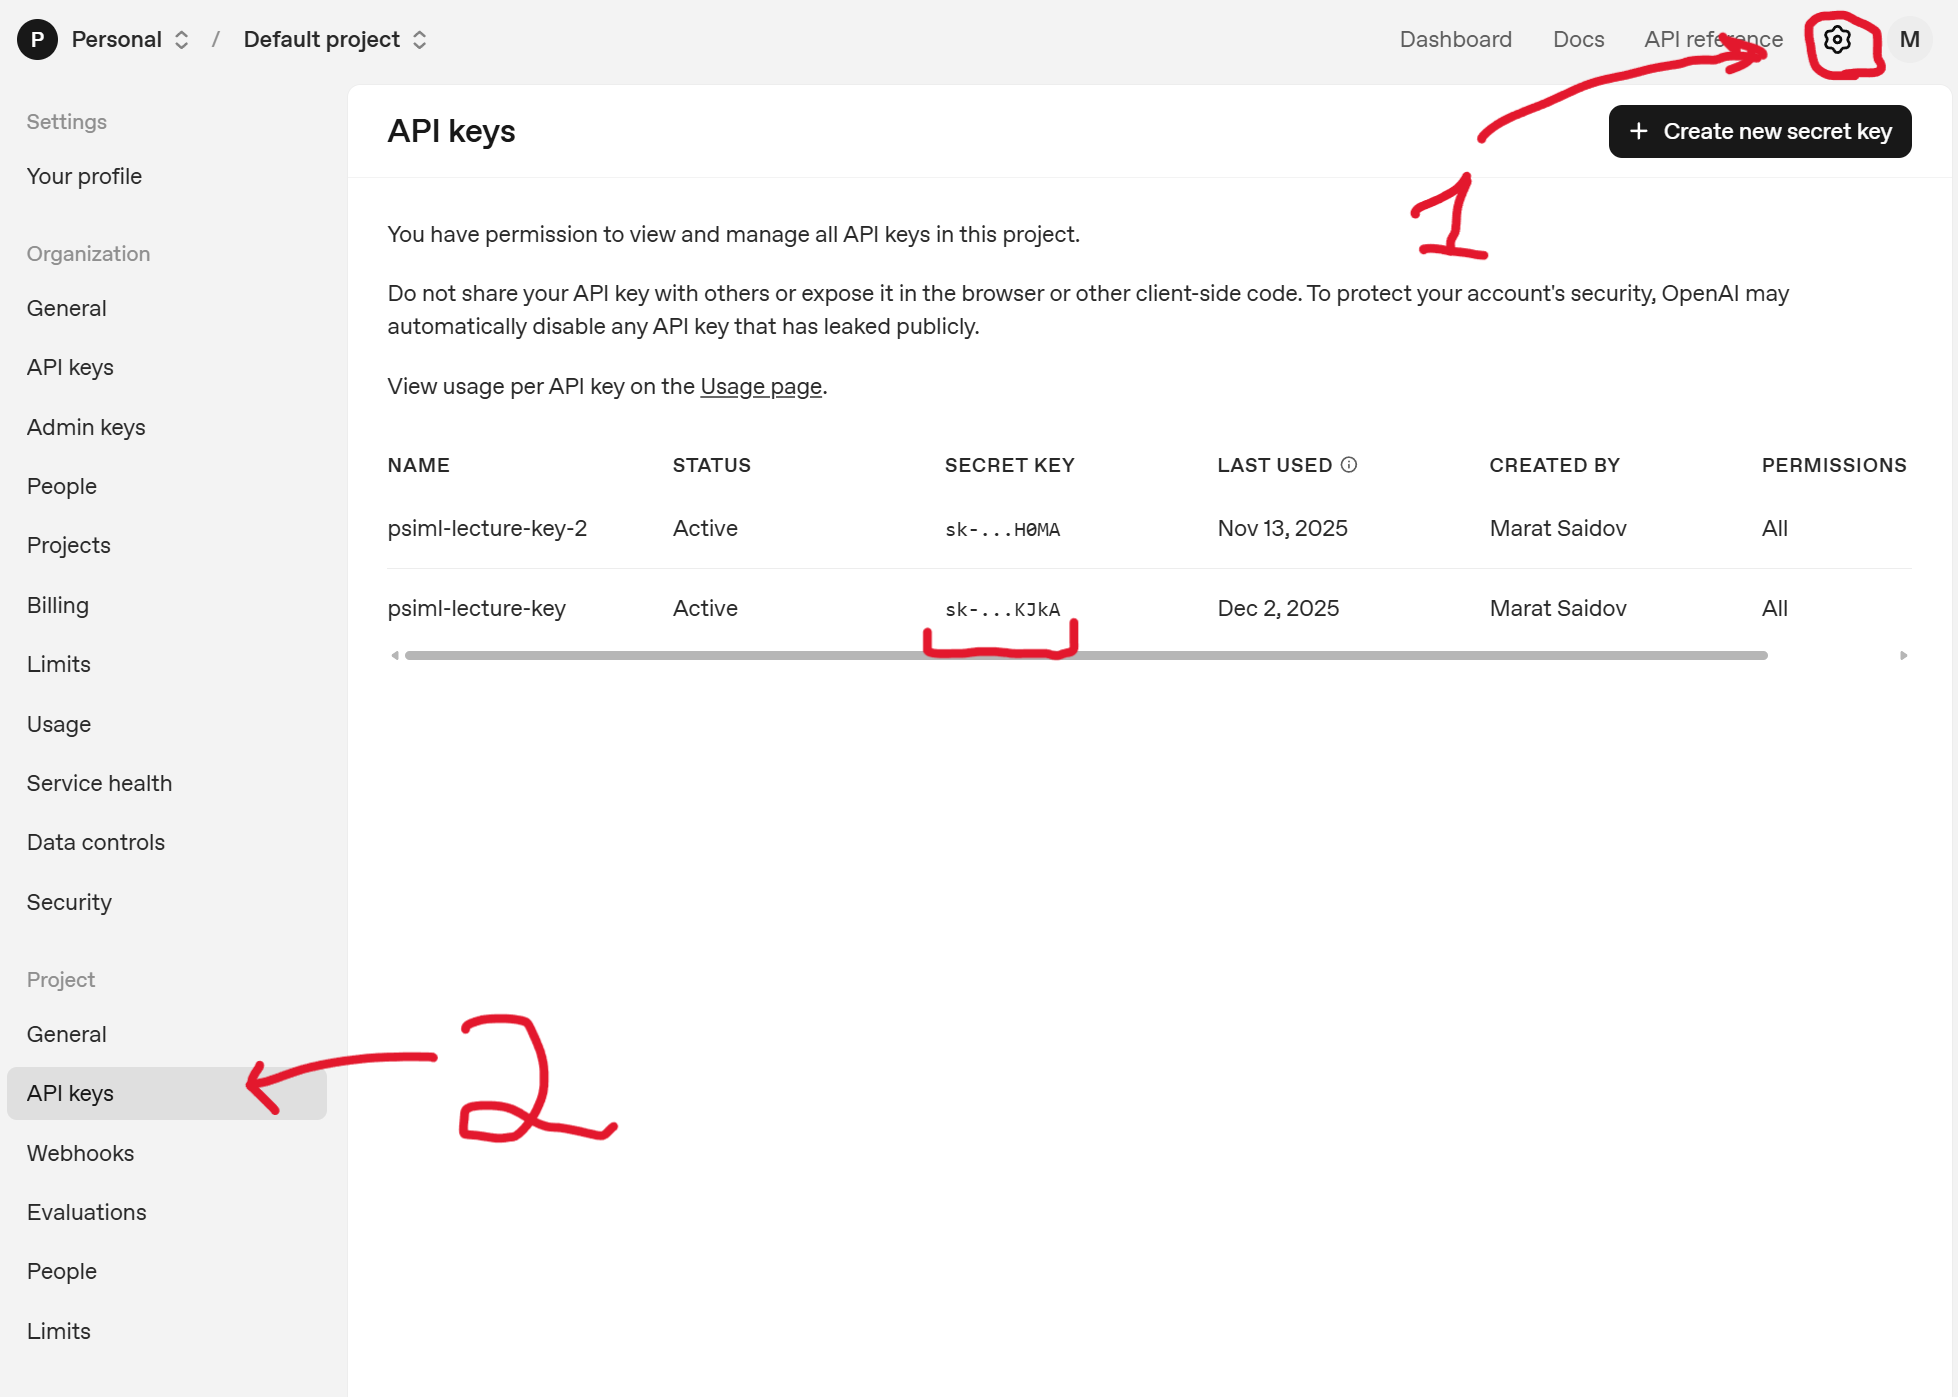

In [ ]:
from IPython.display import Image

Image(filename="/content/psiml-applied-ai/notebooks/attachments/OpenAI-Platform-Key.png", width=1000)

In [ ]:
import os
from pathlib import Path

from openai import OpenAI


api_key = Path(os.getcwd()).joinpath("./api_keys/.openai").read_text().strip()
client = OpenAI(api_key=api_key)

In [ ]:
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": "What is machine learning in one sentence?"}
    ]
)

print(response.choices[0].message.content)

Machine learning is a branch of artificial intelligence that involves the development of algorithms and statistical models enabling computers to improve their performance on a task through experience and data.


**Composing a simple conversation:**

In [ ]:
conversation = [
    {"role": "system", "content": "You are a helpful math tutor."},
    {"role": "user", "content": "What is 15 * 7?"},
]


response1 = client.chat.completions.create(
    model="gpt-4o",
    messages=conversation
)

print(f"User: {conversation[-1]['content']}")
print(f"Assistant: {response1.choices[0].message.content}")


User: What is 15 * 7?
Assistant: 15 multiplied by 7 is 105.


In [ ]:
# Add the assistant's response to the conversation
conversation.append({
    "role": "assistant",
    "content": response1.choices[0].message.content
})

# Continue the conversation
conversation.append({
    "role": "user",
    "content": "Now divide that by 3"
})

In [ ]:
response2 = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=conversation
)

print(f"User: {conversation[-1]['content']}")
print(f"Assistant: {response2.choices[0].message.content}")


User: Now divide that by 3
Assistant: 105 divided by 3 is 35.


#### Sampling parameters

**temperature**. Controls the randomness of predictions by scaling the probability distribution:

- Zero temperature: deterministic (greedy) sampling.
- Low temperature (0.1-0.3): Focused, conservative, factual
- High temperature (0.7-1.0): Creative, natural

**top-p (nucleus sampling)**. Selects from the smallest set of tokens whose cumulative probability exceeds p.

Example: If top_p = 0.9 and we have the conditional probabilities for the next token:
- "blue" (60%)
- "clear" (20%)
- "beautiful" (10%)
- "gray" (5%)

We'd consider only "blue", "clear", and "beautiful" (totaling 90%).

**top-k sampling**. OpenAI's API doesn't directly expose top_k parameter, but it's important to understand as it's used in many other LLM APIs (like Anthropic, Google, open-source models).

Example: If top_k = 3 and we have the conditional probabilities for the next token:
- "blue" (60%)
- "clear" (20%)
- "beautiful" (10%)
- "gray" (5%)

We'd only consider "blue", "clear", and "beautiful" (the top 3).

#### Example: Machine Translation via system prompt specification

In [ ]:
import os

EN_TO_SR_TRANSLATION_PROMPT = """You are a professional English to Serbian translator.
Your task is to translate English text into Serbian accurately and naturally.

Rules:
- Translate the given English text to Serbian
- Maintain the tone and style of the original text
- Use natural Serbian expressions where appropriate
- Only output the translated text, nothing else
- Do not add explanations or notes"""


class EnglishToSerbianTranslator:
    def __init__(self, api_key=None):
        assert api_key is not None, "API key must be provided"
        self.client = OpenAI(api_key=api_key)
        self.model = "gpt-5"
        self.max_completion_tokens = 512
        self.system_prompt = EN_TO_SR_TRANSLATION_PROMPT

    def run(self, user_input):
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                max_completion_tokens=self.max_completion_tokens,
                messages=[
                    {
                        "role": "system",
                        "content": self.system_prompt
                    },
                    {
                        "role": "user",
                        "content": user_input
                    }
                ]
            )
            translated_text = response.choices[0].message.content
            return translated_text
        except Exception as e:
            return f"Error during translation: {str(e)}"

In [ ]:
translator = EnglishToSerbianTranslator(api_key=api_key)

In [ ]:
translator.run("Hello, how are you doing?")

'Zdravo, kako si?'

In [ ]:
translator.run("What's the capital of Serbia?")

'Koji je glavni grad Srbije?'

#### Tricky examples

In [ ]:
client = OpenAI(api_key=api_key)

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": "How many Rs are in the word 'strawberry'?"}
    ]
)

print(response.choices[0].message.content)

The word "strawberry" contains 2 Rs.


*Why?*

In the "strawberry" example, the model is unable to correctly count the 'R's because it is not processing the individual letters. It is simply processing the sequence of 3 token IDs (496, 675, 15717).

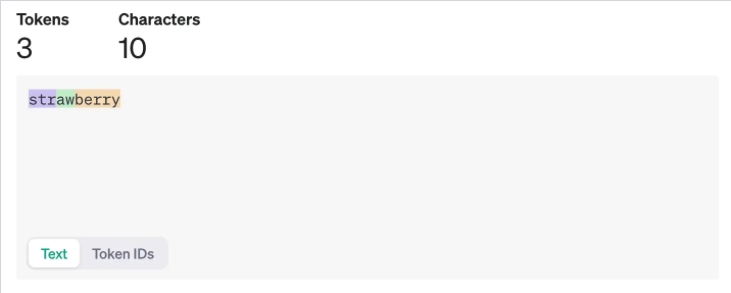

In [3]:
from IPython.display import Image
Image(filename="/content/psiml-applied-ai/notebooks/attachments/Strawberries-Tokenization.png", width=600)

### Practical Production Concerns

**Token counting and cost estimation**. To estimate the costs properly, we need to know:
- How many API calls per day/week?
- Typical input/output length?
- See per-token models' prices

*Example*: we have a "homework helper" app with 100 daily users. It serves 20 questions / user per day. In total, we have => 60,000 questions / month. Average input size = 100 tokens, output size = 150 tokens. <br>
Input processing price: 1.25 * 6 = 7.5 <br>
Output processing price: 10 * 7.5 = 75 <br>
Total price: $82.5 / month.



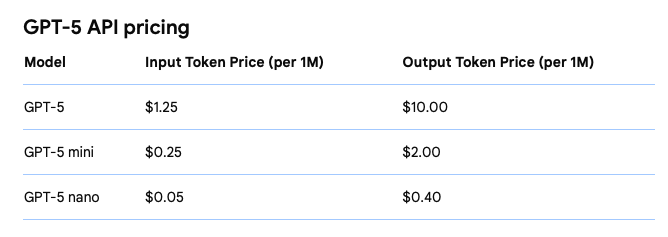

In [4]:
Image(filename="/content/psiml-applied-ai/notebooks/attachments/GPT-5-api-pricing.png", width=600)

Other practical concerns for LLM API apps:

**Streaming responses**. In many use cases we are interested to see the continuous generation rather than retrieving outputs after the generation is completed.

**Async / Concurrent requests**. Batch processing helps to reduce costs.

**Rate limiting**. There should be the upper bound on the number of requests sent from the clients per hour / day / week.

## Running Small Language Models (SLMs) Locally

Key differences:

| Aspect | SLMs | LLMs |
|:-------|:-----|:-----|
| **Size** | 0.5B - 7B parameters | 7B - 405B+ parameters |
| **Memory** | 1-14 GB | 14-810+ GB |
| **Speed** | Fast (local inference) | Slower (API/large hardware) |
| **Cost** | Free/low (run locally) | API costs per token |
| **Capabilities** | Good for focused tasks | Better at complex reasoning |
| **Deployment** | Edge devices, mobile | Cloud/high-end servers |


#### Models selection and loading

1. **Llama 3.2** (Meta)
   - 1B and 3B variants
   - Excellent instruction following
   - Good balance of quality and speed

2. **Qwen 2.5** (Alibaba)
   - 0.5B, 1.5B, 3B, 7B variants
   - Strong multilingual support
   - Good code generation

3. **Phi-3.5** (Microsoft)
   - Mini (3.8B) and Small (7B)
   - High quality despite small size
   - Trained on synthetic data

In [ ]:
MODEL_CONFIGS = {
    "llama-3.2-3b": "Llama-3.2-3B-Instruct",
    "qwen-1.5b": "Qwen2.5-1.5B-Instruct",
    "phi-3.5-mini": "Phi-3.5-mini-instruct",
}

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

SELECTED_MODEL = "qwen-1.5b"
model_name = MODEL_CONFIGS[SELECTED_MODEL]

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    trust_remote_code=True
)

In [ ]:
import time
import torch


def generate_text(
    prompt: str,
    max_new_tokens: int = 512,
    temperature: float = 0.7,
    top_p: float = 0.9,
    system_message: str = "You are a helpful AI assistant."
) -> tuple[str, float]:
    """
    Generate text using the loaded model.

    Returns:
        Tuple of (generated_text, inference_time_seconds)
    """
    # Format prompt based on model
    if "llama" in SELECTED_MODEL.lower():
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt}
        ]
        formatted_prompt = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
    elif "qwen" in SELECTED_MODEL.lower():
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt}
        ]
        formatted_prompt = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
    elif "phi" in SELECTED_MODEL.lower():
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt}
        ]
        formatted_prompt = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
    else:
        formatted_prompt = prompt

    # Tokenize
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)

    # Generate
    start_time = time.time()
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    inference_time = time.time() - start_time

    # Decode
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

    return generated_text, inference_time

In [ ]:
prompt = "Write a short poem about the beauty of autumn leaves falling in a forest."

generated_poem, inference_time = generate_text(
    prompt=prompt,
    max_new_tokens=256,
    temperature=0.8,  # Higher temperature for more creative output
    top_p=0.95,
    system_message="You are a talented poet known for vivid imagery and emotional depth."
)

print("=== POETRY GENERATION EXAMPLE ===\n")
print(f"📝 Prompt: {prompt}\n")
print(f"🎨 Generated Poem:\n{generated_poem}\n")
print(f"⏱️ Inference Time: {inference_time:.2f}s")

=== POETRY GENERATION EXAMPLE ===

📝 Prompt: Write a short poem about the beauty of autumn leaves falling in a forest.

🎨 Generated Poem:
Leaves dance upon the silent night,
In hues that sing a melancholy tune.
The world asleep, yet alive again,
As winds whisper secrets to the pine.

Each leaf a story from ancient trees,
A memory of days so very free.
From sun-kissed branches now adrift,
Into the earth's embrace they drift.

Falling softly on the forest floor,
A symphony without a stringed friend.
They whisper tales beneath the moonlight,
Of nature's quiet magic unshaken.

In this season of change and cool,
Nature's palette paints us with joyous fright.
For though it marks our time's decay,
Beauty endures in all its fall.

⏱️ Inference Time: 15.49s


#### Use cases

**Summarization**.

In [ ]:
def summarize_document(doc: str, length: str = "medium") -> dict:
    length_instructions = {
        "short": "in 1-2 concise sentences",
        "medium": "in 3-4 sentences",
        "long": "in a detailed paragraph"
    }
    max_tokens = {
        "short": 100,
        "medium": 150,
        "long": 300
    }
    prompt = f"""Summarize the following text {length_instructions[length]}:

{doc}

Summary:"""
    summary, time_taken = generate_text(
        prompt,
        max_new_tokens=max_tokens[length],
        temperature=0.3,  # Lower temperature for more focused summaries
        system_message="You are an expert at creating clear, accurate summaries."
    )
    return {
        "summary": summary.strip(),
        "time": time_taken,
        "length": length
    }


In [ ]:
import time

sample_document = """
Coral reefs are among the most biodiverse ecosystems on Earth, supporting approximately
25% of all marine species despite covering less than 1% of the ocean floor. These underwater
structures are built by tiny colonial animals called coral polyps that form symbiotic relationships
with zooxanthellae, photosynthetic algae living within their tissues. The algae provide energy
through photosynthesis while corals provide protection and access to sunlight. Sadly, coral reefs
face unprecedented threats from climate change, ocean acidification, pollution, and overfishing.
Rising sea temperatures cause coral bleaching, where stressed corals expel their algal partners,
often leading to death. Conservation efforts including marine protected areas, sustainable fishing
practices, and climate action are critical to preserve these vital ecosystems for future generations.
"""

print("=== SUMMARIZATION EXAMPLES ===\n")

for length in ["short", "medium", "long"]:
    result = summarize_document(sample_document, length=length)
    print(f"📌 Length: {length.upper()}")
    print(f"Summary: {result['summary']}")
    print(f"⏱️ Time: {result['time']:.2f}s\n")

=== SUMMARIZATION EXAMPLES ===

📌 Length: SHORT
Summary: Coral reefs, home to a quarter of all marine life, are threatened by global warming, ocean acidification, pollution, and unsustainable fishing practices, with conservation efforts crucial for preserving them for future generations.
⏱️ Time: 4.81s

📌 Length: MEDIUM
Summary: Coral reefs, with their high biodiversity and unique ecosystem, support a significant portion of marine life but cover only about 1% of the ocean floor. They are formed by coral polyps forming symbiotic relationships with zooxanthellae, which provide energy through photosynthesis. However, they face severe threats such as rising sea temperatures causing coral bleaching, ocean acidification, pollution, and overfishing. Conservation measures like marine protected areas, sustainable fishing practices, and addressing climate change are crucial to preserving these valuable ecosystems for future generations.
⏱️ Time: 7.11s

📌 Length: LONG
Summary: Coral reefs, with t

**Paraphrasing**.

In [ ]:
def paraphrase_text(text: str, style: str = "neutral") -> dict:
    style_instructions = {
        "formal": "Rewrite this in a formal, professional tone",
        "casual": "Rewrite this in a casual, conversational tone",
        "neutral": "Paraphrase this while maintaining a neutral tone",
        "technical": "Rewrite this using more technical and precise terminology"
    }
    prompt = f"""{style_instructions[style]}:

Original: {text}

Rewritten version:"""
    paraphrase, time_taken = generate_text(
        prompt,
        max_new_tokens=200,
        temperature=0.7,
        system_message="You are an expert at rewriting and paraphrasing text."
    )
    return {
        "original": text,
        "paraphrase": paraphrase.strip(),
        "style": style,
        "time": time_taken
    }

In [ ]:
original_text = "The forest ecosystem depends on the balance between trees, animals, and soil organisms working together."

print("=== PARAPHRASING EXAMPLES ===\n")

for style in ["neutral", "formal", "casual", "technical"]:
    result = paraphrase_text(original_text, style=style)
    print(f"🎯 Style: {style.upper()}")
    print(f"Original: {result['original']}")
    print(f"Paraphrased: {result['paraphrase']}")
    print(f"⏱️ Time: {result['time']:.2f}s\n")

=== PARAPHRASING EXAMPLES ===

🎯 Style: NEUTRAL
Original: The forest ecosystem depends on the balance between trees, animals, and soil organisms working together.
Paraphrased: The intricate web of life within the forest relies on the harmonious interplay among trees, wildlife, and microbial communities.
⏱️ Time: 2.42s

🎯 Style: FORMAL
Original: The forest ecosystem depends on the balance between trees, animals, and soil organisms working together.
Paraphrased: The intricate forest ecosystem relies upon the harmonious interplay among tree species, fauna, and microorganisms within the soil matrix.
⏱️ Time: 1.52s

🎯 Style: CASUAL
Original: The forest ecosystem depends on the balance between trees, animals, and soil organisms working together.
Paraphrased: The forest is like a big puzzle where all the pieces (trees, critters, and tiny creatures) fit perfectly to make everything work!
⏱️ Time: 1.75s

🎯 Style: TECHNICAL
Original: The forest ecosystem depends on the balance between trees, ani

## Image Captioning with Vision-Language Models (VLMs)

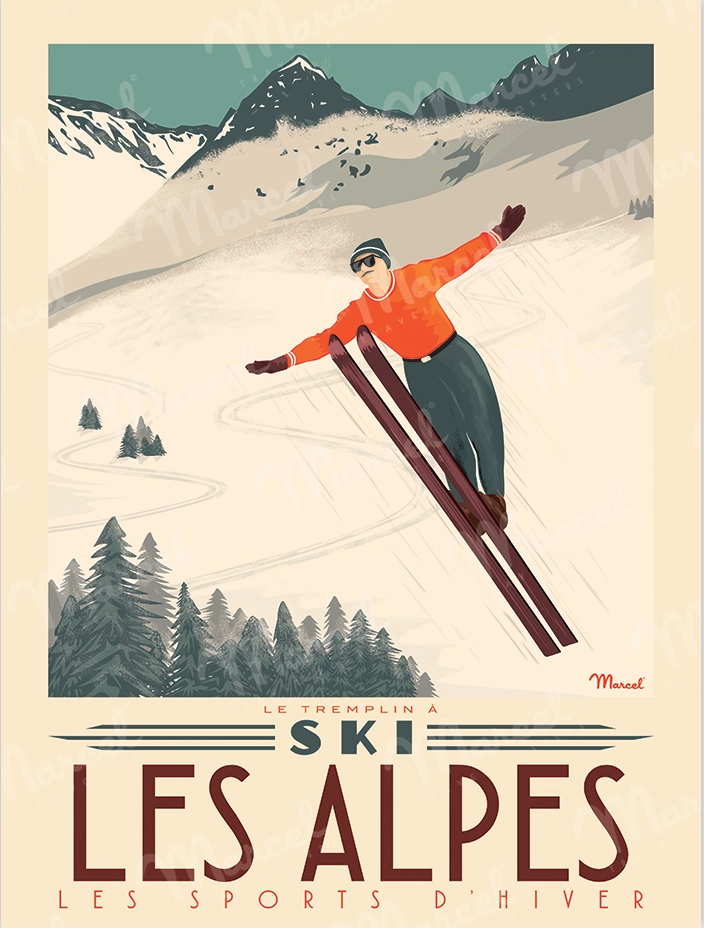

In [6]:
Image(filename="/content/psiml-applied-ai/notebooks/attachments/Skiing-In-Alpes-Poster.png", width=400)

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq

model_name = "Qwen/Qwen2-VL-2B-Instruct"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForVision2Seq.from_pretrained(
    model_name,
    device_map="auto"
)

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
/Users/msaidov/.pyenv/versions/psiml-nlp/lib/python3.13/site-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from PIL import Image
import torch

# Load image and process
image_path = "attachments/Skiing-In-Alpes-Poster.png"
image = Image.open(image_path)
question = "What activity is happening in this image?"

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": question}
        ],
    }
]

text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(text=[text], images=[image], return_tensors="pt").to(model.device)

with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=256)

response = processor.decode(output[0], skip_special_tokens=True)
print(response)

system
You are a helpful assistant.
user
What activity is happening in this image?
assistant
The image depicts a person skiing.
